In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import re

# GLOBAL FIGURE SETTINGS

figsize = (3.5, 2.7)
fontsize = 11
linewidth = 2
markersize = 5
legend_fontsize = 9

labelspacing = 0

layer_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# set figure size
plt.rcParams['figure.figsize'] = figsize
# plt.rcParams['font.family'] = 'sans-serifX'
# plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': fontsize})
plt.rcParams['lines.linewidth'] = linewidth
plt.rcParams['lines.markersize'] = markersize
plt.rcParams['legend.fontsize'] = legend_fontsize


# Color gradient
# colors = cm.plasma(np.linspace(0, 1, len(dims)+1))
# colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(dims)+1))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

# get matplotlib v2 default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# set labelspacing
plt.rcParams['legend.labelspacing'] = labelspacing

# activate grid
plt.rcParams['axes.grid'] = True

epochs_ticks = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])

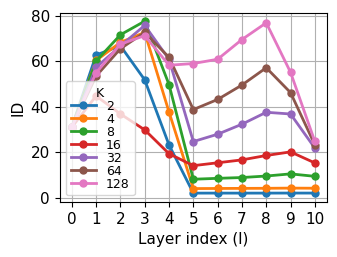

In [2]:
# Load the JSON data
with open("IDs_test.json") as f:
    data = json.load(f)

# Settings
epoch = 200
dims = [2, 4, 8, 16, 32, 64, 128]
layers = np.arange(11)  # Layer indices: 0 to 10

# Initialize the plot
plt.figure()

# Loop over latent dimensions and plot the data
for i, dim in enumerate(dims):
    dim_key = f"dim_{dim}"
    epoch_key = f"epoch_{epoch}"

    values = data[dim_key][epoch_key]
    plt.plot(layers, values, label=f"{dim}", marker='o')

plt.xlabel("Layer index (l)")
plt.ylabel("ID")
plt.xticks(ticks=layers, labels=[f"{i}" for i in layers])
plt.legend(loc='lower left', title = "K", title_fontsize=legend_fontsize)

# use a tight layout and specifically leave enough soace on the left
plt.tight_layout()

plt.savefig("IDs_over_layers.png", dpi=300)
plt.show()



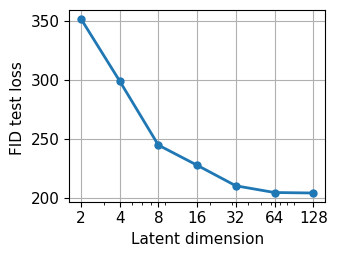

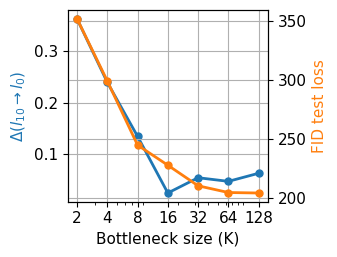

In [12]:
# Open the Information Imbalance (II) dictionary
with open("IIs_first_last.json", "r") as f:
    IIs = json.load(f)

imbs = []
for i, dim in enumerate(dims):
    IIs_ = IIs[f"dim_{dim}_epoch_{epoch}"]
    II_to_first = IIs_["to_first"][-1]
    II_to_last = IIs_["to_last"][0]
    #rel_diff = (II_to_first - II_to_last) / (II_to_first + II_to_last)/2
    imbs.append( II_to_first)
    
    
loss_dir = "losses_fid_test"
losses = {}

pattern = re.compile(r"epoch_200_dim_(\d+)\_fid_loss.txt")
for filename in os.listdir(loss_dir):
    match = pattern.match(filename)
    if match:
        dim = int(match.group(1))  # Extract the dimension from filename
        file_path = os.path.join(loss_dir, filename)
        with open(file_path, 'r') as f:
            line = f.readline()
            loss_value = float(line)

        # Store the loss value for the corresponding dimension
        losses[dim] = loss_value

# Sort losses by dimension
sorted_dims = sorted(losses.keys())
sorted_losses = [losses[dim] for dim in sorted_dims]
plt.figure()
plt.plot(sorted_dims, sorted_losses, marker='o')

plt.xlabel('Latent dimension')
plt.ylabel('FID test loss ')
plt.xscale('log')

# set xticks
plt.xticks(sorted_dims, labels=[f"{dim}" for dim in sorted_dims])

plt.tight_layout()
plt.savefig("loss_vs_dim.png", dpi=300)
plt.show()


# create a figure with two axes (left and right)
fig, ax1 = plt.subplots()

# on the first axis, plot the Information Imbalance
ax1.plot(dims, imbs, marker='o', color=colors[0])
# on the second axis, plot the FID loss
ax2 = ax1.twinx()
ax2.plot(sorted_dims, sorted_losses, marker='o', color=colors[1])

ax1.set_xlabel('Bottleneck size (K)')
ax1.set_ylabel(r'$\Delta(l_{10}\rightarrow l_0)$', color=colors[0])
ax2.set_ylabel('FID test loss', color=colors[1])
ax1.set_xscale('log')
ax1.set_xticks(dims, dims)
plt.tight_layout()

plt.savefig("II_and_loss_vs_dim.png", dpi=300)
plt.show()




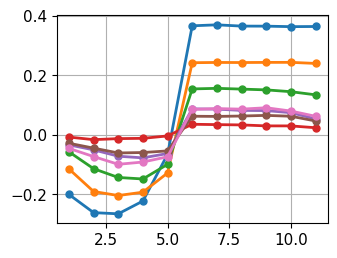

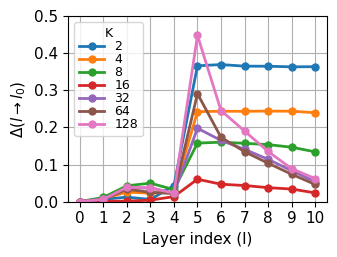

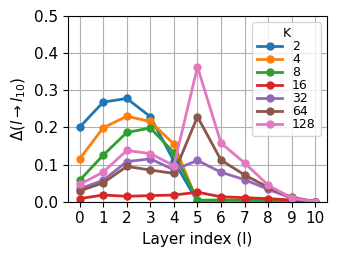

In [4]:
# Open the Information Imbalance (II) dictionary
with open("IIs_first_last.json", "r") as f:
    IIs = json.load(f)

imb_gap = []
for i, dim in enumerate(dims):
    IIs_ = IIs[f"dim_{dim}_epoch_{epoch}"]
    
    layers = list(range(1, len(IIs_["to_last"]) + 1))

    plt.plot(layers, np.array(IIs_["to_first"]) - np.array(IIs_["to_last"]), label=f"{dim}", linestyle='-', marker='o')
    imb_gap.append( IIs_["to_first"][-1] - IIs_["to_first"][0])


# Define epoch and dimensions to plot
epoch = 200  # Plot for epoch 200
dims = [2, 4, 8, 16, 32, 64, 128]

plt.figure()
for i, dim in enumerate(dims):
    IIs_ = IIs[f"dim_{dim}_epoch_{epoch}"]
    layers = list(range(1, len(IIs_["to_first"]) + 1))
    plt.plot(layers, IIs_["to_first"], label=f"{dim}", linestyle='-', marker='o')
plt.xlabel("Layer index (l)")
plt.ylabel(r"$ \Delta(l \rightarrow l_0)$")
plt.legend(loc='upper left', title="K", title_fontsize=legend_fontsize)
plt.xticks(layers, layer_indices)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(f"II_all_dims_epoch_{epoch}_to_first.png", dpi=300)

plt.figure()
for i, dim in enumerate(dims):
    IIs_ = IIs[f"dim_{dim}_epoch_{epoch}"]
    layers = list(range(1, len(IIs_["to_last"]) + 1))
    plt.plot(layers, IIs_["to_last"], label=f"{dim}", linestyle='-', marker='o')
plt.xlabel("Layer index (l)")
plt.ylabel(r"$ \Delta(l \rightarrow l_{10})$")
plt.legend(loc='upper right', title="K", title_fontsize=legend_fontsize)
plt.xticks(layers, layer_indices)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(f"II_all_dims_epoch_{epoch}_to_last.png", dpi=300)

plt.show()


/tmp/ipykernel_291346/4124311063.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


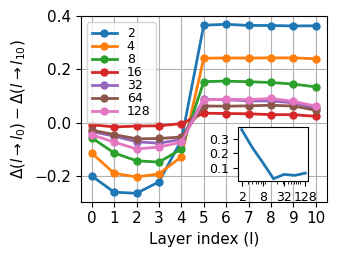

In [5]:
# Open the Information Imbalance (II) dictionary
with open("IIs_first_last.json", "r") as f:
    IIs = json.load(f)


epoch = 200  # Plot for epoch 200
dims = [2, 4, 8, 16, 32, 64, 128]

plt.figure()

# Loop over each dimension to plot "to_first" curves on the same plot
imb_gap = []
for i, dim in enumerate(dims):
    IIs_ = IIs[f"dim_{dim}_epoch_{epoch}"]
    
    layers = list(range(1, len(IIs_["to_last"]) + 1))

    plt.plot(layers, np.array(IIs_["to_first"]) - np.array(IIs_["to_last"]), label=f"{dim}", linestyle='-', marker='o')
    imb_gap.append( IIs_["to_first"][-1] - IIs_["to_first"][0])

plt.xlabel("Layer index (l)")
plt.ylabel(r"$ \Delta(l \rightarrow l_0) - \Delta(l \rightarrow l_{10})$")
plt.legend(loc='upper left')

# plt.ylim(0, 0.5)
plt.xticks(layers, layer_indices)

# now create an inset in the bottom leright corner
# in it, plot the difference between the last and first layer for each dimension
plt.axes([0.7, 0.305, .2, .2])

plt.plot(dims, imb_gap)
plt.xscale('log')
plt.xticks([2, 8, 32, 128], [2, 8, 32, 128], fontsize=9)
plt.yticks(fontsize=9)
# remove grid
plt.grid(False)


plt.tight_layout()

plt.savefig(f"II_all_dims_epoch_{epoch}_to_last_minus_to_first.png", dpi=300)
plt.show()


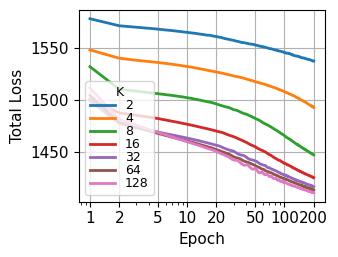

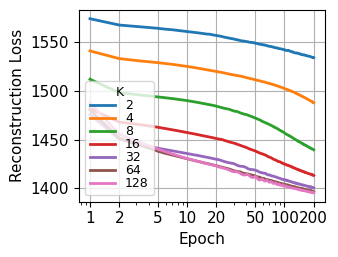

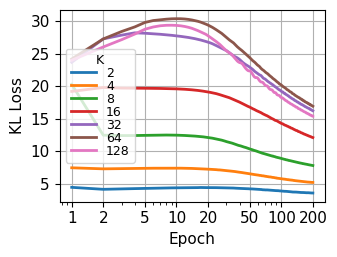

In [6]:
epochs = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])
epochs_ticks = np.array([1, 2, 5, 10, 20, 50, 100, 200])
# Path to the folder containing the .txt files
folder_path = 'new_loss'

# Initialize a dictionary to store losses for each dimension
losses_by_dim = {2: [], 4: [], 8: [], 16: [], 32: [], 64: [], 128: []}

# Regular expression to match filenames like 'loss_epoch_(number)_dim_(number).txt'
file_pattern = re.compile(r'loss_epoch_(\d+)_dim_(\d+)\.txt')

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        match = file_pattern.match(filename)
        if match:
            epoch_ = int(match.group(1))
            dim = int(match.group(2))

            # Read the file content
            with open(os.path.join(folder_path, filename), 'r') as file:
                line = file.readline()
                # Extract the total loss, reconstructed loss, and KL loss from the first part of the line
                # Strip out everything between 'tensor(...)' and after.
                line = line.replace('[','').replace(']','').replace('\n','')
                line = line.split(',')

                total_loss = float(line[0])
                reconstructed_loss = float(line[1])
                kl_loss = float(line[2])

                # Append the losses to the respective dimension list
                losses_by_dim[dim].append((epoch_, total_loss, reconstructed_loss, kl_loss))

# Sort the losses by epoch for each dimension
for dim, losses in losses_by_dim.items():
    losses_by_dim[dim] = sorted(losses, key=lambda x: x[0])

# Plot Total Loss for all dimensions
plt.figure()
for dim, losses in losses_by_dim.items():
    epochs_ = np.array([x[0] for x in losses])
    total_losses = [x[1] for x in losses]
    plt.plot(epochs_, total_losses, label=f'{dim}')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.xscale('log')
plt.xticks(epochs_ticks, epochs_ticks)
plt.legend(title = "K", title_fontsize=legend_fontsize)
plt.tight_layout()  
plt.savefig('total_loss_curves.png', dpi=300)
plt.show()

# Plot Reconstructed Loss for all dimensions
plt.figure()
for dim, losses in losses_by_dim.items():
    epochs = np.array([x[0] for x in losses])
    reconstructed_losses = np.array([x[2] for x in losses])
    plt.plot(epochs, reconstructed_losses, label=f'{dim}')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.xscale('log')
plt.xticks(epochs_ticks, epochs_ticks)
plt.legend(title = "K", title_fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig('reconstrucion_loss_curves.png', dpi=300)
plt.show()

# Plot KL Loss for all dimensions
plt.figure()
for dim, losses in losses_by_dim.items():
    epochs = np.array([x[0] for x in losses])
    kl_losses = [x[3] for x in losses]
    plt.plot(epochs, kl_losses, label=f'{dim}')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.xscale('log')
plt.xticks(epochs_ticks, epochs_ticks)
plt.legend(title = "K", title_fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig('kl_loss_curves.png', dpi=300)
plt.show()


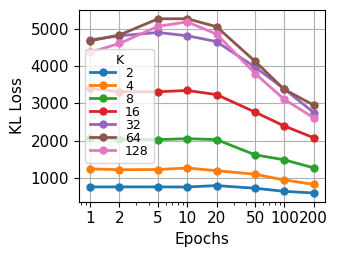

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory where the files are stored
data_dir = "losses_test"

# Define dimensions and epochs
dims = [2, 4, 8, 16, 32, 64, 128]
epochs = [1, 2, 5, 10, 20, 50, 99, 200]

# Initialize a dictionary to store KL loss values for each dimension and epoch
kl_loss_data = {dim: [] for dim in dims}

# Loop through each dimension and epoch to read the data
for dim in dims:
    for epoch in epochs:
        # Construct the file path
        file_path = os.path.join(data_dir, f"epoch_{epoch}_dim_{dim}_kl_loss.txt")
        
        # Check if file exists
        if os.path.exists(file_path):
            # Read the KL loss from the file
            with open(file_path, "r") as file:
                kl_loss = float(file.read().strip())  # Assume the file contains a single loss value
                kl_loss_data[dim].append(kl_loss)
        else:
            kl_loss_data[dim].append(np.nan)  # Handle missing files with NaN

# Plot the data
plt.figure()

for dim in dims:
    plt.plot(epochs, kl_loss_data[dim], marker='o', label=f'{dim}')

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("KL Loss")
plt.xscale("log")
plt.legend(title = "K", title_fontsize=legend_fontsize)

plt.xticks(epochs_ticks, epochs_ticks)
plt.tight_layout()
plt.savefig('kl_loss_curves.png', dpi=300)
# Show the plot
plt.show()

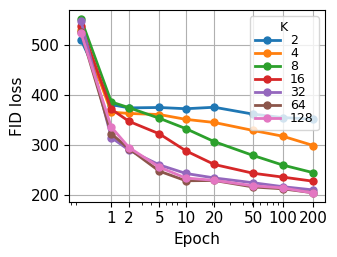

In [8]:
# Path to the folder containing the .txt files
folder_path = 'losses_fid_test'  # Update this to the correct folder path

# Define the dimensions and epochs you're interested in
dims = [2, 4, 8, 16, 32, 64, 128]
epochs = np.array([0, 1, 2, 5, 10, 20, 50, 99, 200])

# Regular expression to match filenames like 'epoch_(number)_dim_(number)_fid_loss.txt'
file_pattern = re.compile(r'epoch_(\d+)_dim_(\d+)_fid_loss\.txt')

# Initialize a dictionary to store FID losses for each dimension
fid_losses_by_dim = {dim: [] for dim in dims}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        match = file_pattern.match(filename)
        if match:
            epoch = int(match.group(1))
            dim = int(match.group(2))

            # Only process the dimensions and epochs we're interested in
            if dim in dims and epoch in epochs:
                # Read the file content (FID loss)
                with open(os.path.join(folder_path, filename), 'r') as file:
                    fid_loss = float(file.readline().strip())

                # Append the epoch and FID loss to the respective dimension list
                fid_losses_by_dim[dim].append((epoch, fid_loss))

# Sort the FID losses by epoch for each dimension
for dim in fid_losses_by_dim:
    fid_losses_by_dim[dim] = sorted(fid_losses_by_dim[dim], key=lambda x: x[0])

# Plot FID Loss for all dimensions over the specified epochs
plt.figure()
for dim, losses in fid_losses_by_dim.items():
    epochs_sorted = np.array([x[0] for x in losses])
    fid_losses_sorted =  np.array([x[1] for x in losses])
    plt.plot(epochs_sorted+1, fid_losses_sorted, label=f'{dim}', marker='o')

plt.xscale('log')

plt.xticks(epochs_ticks+1, epochs_ticks)
plt.xlabel('Epoch')
plt.ylabel('FID loss')
plt.legend(title = "K", title_fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig('fid_loss_curves.png', dpi=300)
plt.show()


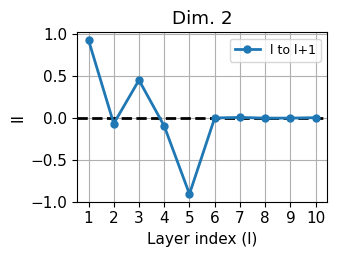

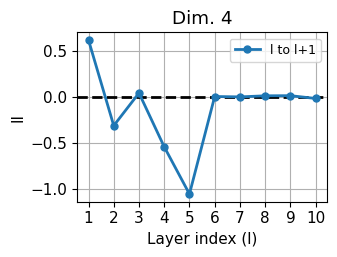

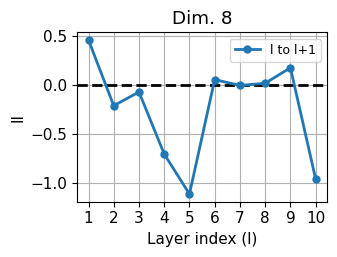

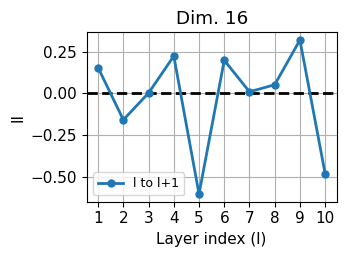

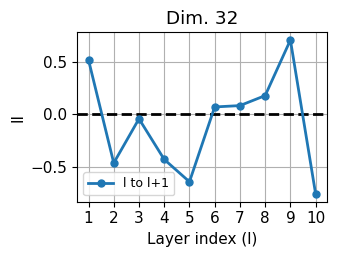

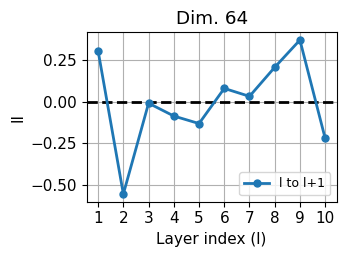

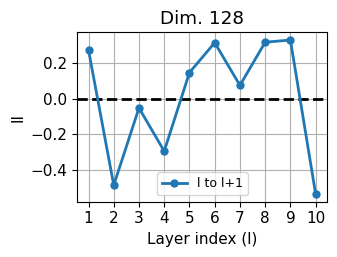

In [9]:
# Path to the single JSON file
json_file_path = 'IIs_train.json'

# Define the dimensions and the target epoch
dims = [2, 4, 8, 16, 32, 64, 128]
target_epoch = 200

# Initialize a dictionary to store the data
data = {}

# Load the JSON data from the file
with open(json_file_path, 'r') as f:
    json_data = json.load(f)
    
    # Loop through the keys and extract data for the target epoch and dimensions
    for key, values in json_data.items():
        key_parts = key.split('_')
        dim = int(key_parts[1])
        epoch = int(key_parts[3])
        
        # Filter for the target epoch
        if epoch == target_epoch and dim in dims:
            data[dim] = {
                'l1_to_l2': values['l1_to_l2'],
                'l2_to_l1': values['l2_to_l1']
            }

# Loop through each dimension and create a separate plot for each
for dim in dims:
    if dim in data:
        l_values = list(range(1, len(data[dim]['l1_to_l2']) + 1))
        
        # Create a figure for each dimension
        plt.figure()
        
        # Plot l1_to_l2 and l2_to_l1 on the same graph
        l1l2 = np.array(data[dim]['l1_to_l2'])
        l2l1 = np.array(data[dim]['l2_to_l1'])
        mean = (abs(l1l2) + abs(l2l1)) / 2
   
        plt.axhline(0, color='black', linestyle='--')
        plt.plot(l_values, (l1l2 - l2l1)/mean, label='l to l+1', marker = 'o')
        
        # Add title and labels
        plt.title(f'Dim. {dim}')
        plt.xlabel('Layer index (l)')
        # plt.yscale('log')
        plt.ylabel('II')
        
        plt.xticks(l_values, l_values)
        # Add legend and grid
        plt.legend()
        
        # Save the figure to a file
        plt.tight_layout()
        plt.savefig(f'imbalance_plot_dim_{dim}_epoch_{target_epoch}.png')
        plt.show()
        plt.close()  # Close the figure after saving
        
        

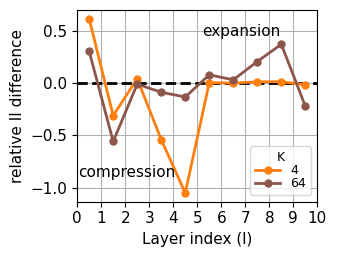

In [10]:

plt.figure()

dims = [32, 64, 128]
dims = [4, 64]

plt.axhline(0, color='black', linestyle='--')

color_indices = [1, 5]
# Loop through each dimension and create a separate plot for each
for i, dim in enumerate(dims):
    if dim in data:
        l_values = list(range(1, len(data[dim]['l1_to_l2']) + 1))
        l_values = np.array(l_values)
        # Plot l1_to_l2 and l2_to_l1 on the same graph
        l1l2 = np.array(data[dim]['l1_to_l2'])
        l2l1 = np.array(data[dim]['l2_to_l1'])
        mean = (abs(l1l2) + abs(l2l1)) / 2
        
        # plt.plot(l_values, data[dim]['l1_to_l2'], label='l to l+1', marker = 'o')
        # plt.plot(l_values, data[dim]['l2_to_l1'], label='l+1 to l', marker = 'o')
    
        plt.plot(l_values-0.5, (l1l2 - l2l1)/mean, label=f"{dim}", marker = 'o', color = colors[color_indices[i]])
        
        
# annotate somewhere around zero and name it "expansion"
plt.annotate('expansion', xy=(8, 0.3), xytext=(5.2, .45))
# annotate somewhere around zero and name it "compression"
plt.annotate('compression', xy=(3, -0.3), xytext=(0.05, -0.9))
        
# Add title and labels
plt.xlabel('Layer index (l)')
# plt.yscale('log')
plt.ylabel('relative II difference')

plt.xticks(np.arange(0, 11), np.arange(0, 11))

# plot a legend on the side
plt.legend(loc='lower right', title = "K", title_fontsize=legend_fontsize)

# Save the figure to a file
plt.tight_layout()
plt.savefig(f'imbalance_plot_rel_diff.png', dpi = 300)
plt.show()
plt.close()  # Close the figure after saving
    
        

Plotting for dimensions: 2 and 4


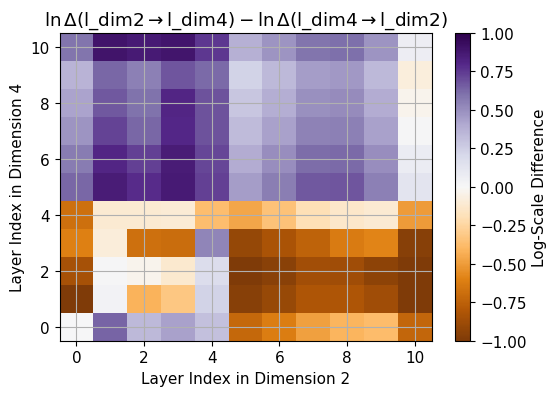

Plotting for dimensions: 4 and 8


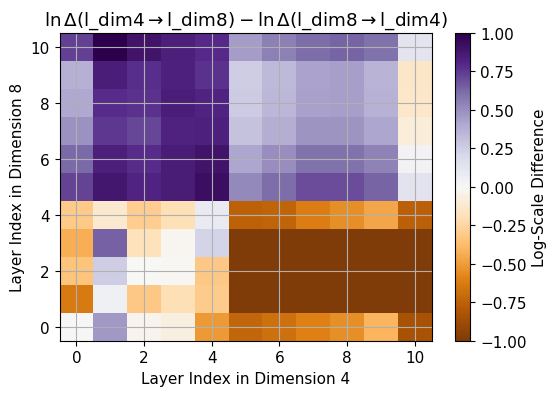

Plotting for dimensions: 8 and 16


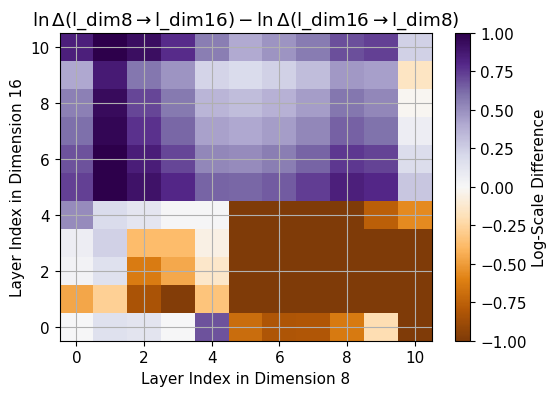

Plotting for dimensions: 16 and 32


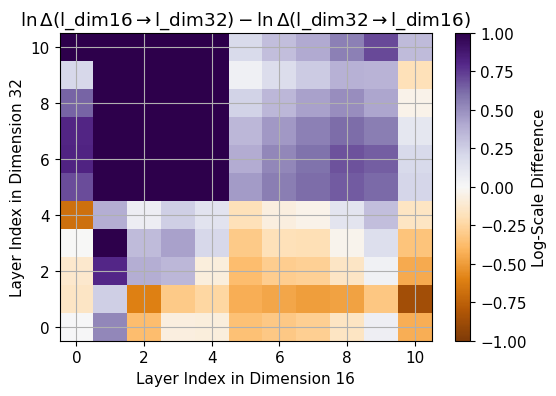

Plotting for dimensions: 32 and 64


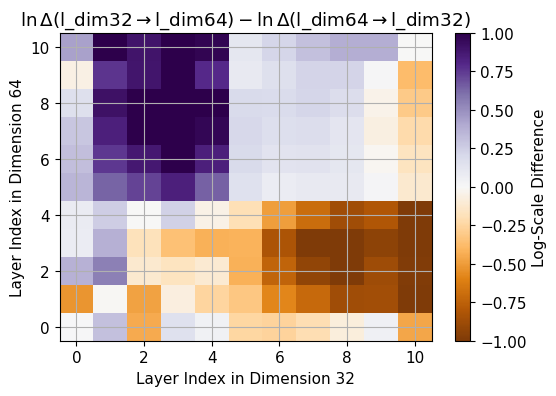

Plotting for dimensions: 64 and 128


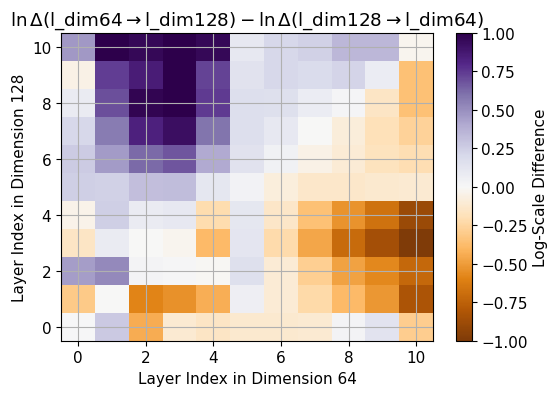

Plotting for dimensions: 64 and 16


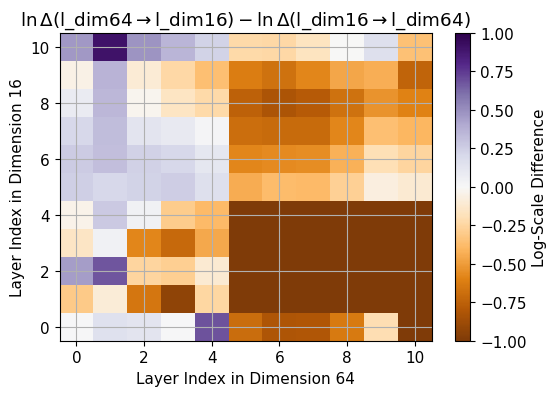

Plotting for dimensions: 64 and 8


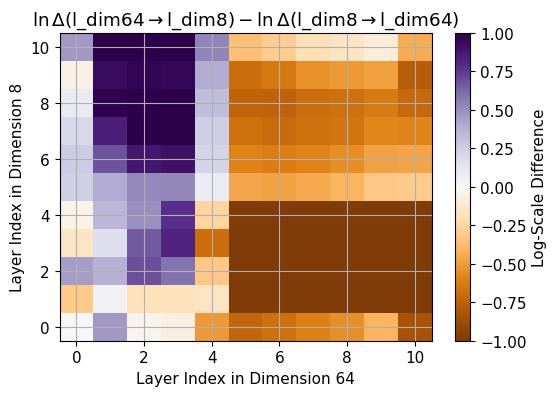

Plotting for dimensions: 64 and 4


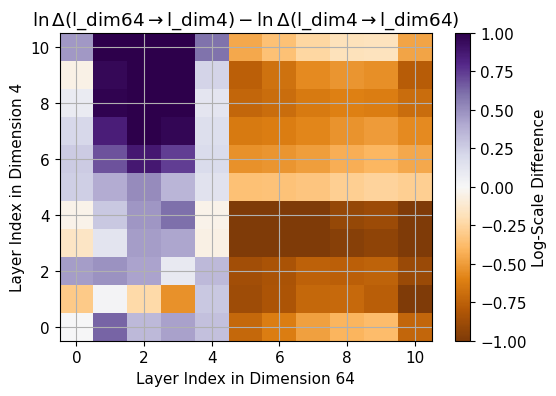

Plotting for dimensions: 64 and 64


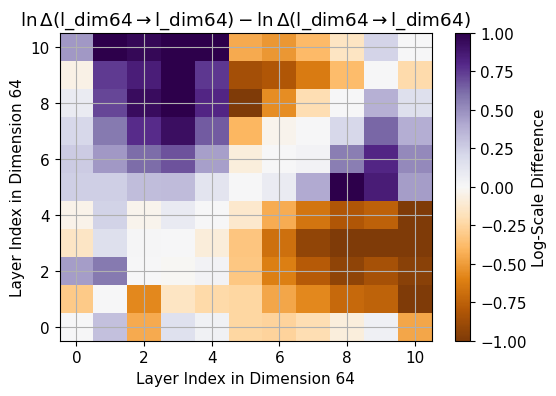

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the dimensions, layers, and specific pairs of dimensions to plot
dims = [2, 4, 8, 16, 32, 64, 128]
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dim_pairs = [(2, 4), (4, 8), (8, 16), (16, 32), (32, 64), (64,128), (64, 16), (64, 8), (64, 4), (64,64)]

# Function to compute the log-scale difference between II matrices
def compute_logscale_diff(dim1, dim2):
    # Load cross-II data from files for dim1 to dim2 and dim2 to dim1
    file_path_1to2 = f"cross_IIs/dim_{dim1}_dim_{dim2}_cross_IIs.np.npy"
    file_path_2to1 = f"cross_IIs/dim_{dim2}_dim_{dim1}_cross_IIs.np.npy"
    
    II1_2 = np.load(file_path_1to2)  # II from dim1 to dim2
    II2_1 = np.load(file_path_2to1)  # II from dim2 to dim1
    
    num_layers = len(layers)
    log_diff = np.zeros((num_layers, num_layers))
    
    for i in range(num_layers):
        for j in range(num_layers):
            val_1to2 = II1_2[i, j]
            val_2to1 = II2_1[j, i]
            
            # Avoid log(0) by setting values <= 0 to NaN
            val_1to2 = val_1to2 if val_1to2 > 0 else np.nan
            val_2to1 = val_2to1 if val_2to1 > 0 else np.nan
            
            # Calculate log-scale difference only if both values are non-NaN
            if not np.isnan(val_1to2) and not np.isnan(val_2to1):
                log_diff[i, j] = np.log(val_1to2) - np.log(val_2to1)
            else:
                log_diff[i, j] = np.nan
    
    return log_diff

# Function to plot the log-scale difference for each dimension pair
def plot_logscale_diff(dim1, dim2):
    log_diff = compute_logscale_diff(dim1, dim2)
    
    plt.figure(figsize=(6, 4))
    
    # Plot the log-scale difference matrix
    c = plt.pcolormesh(layers, layers, log_diff, shading='auto', cmap='PuOr', vmin=-1, vmax=1)
    plt.colorbar(c, label='Log-Scale Difference')
    
    plt.xlabel(f'Layer Index in Dimension {dim1}')
    plt.ylabel(f'Layer Index in Dimension {dim2}')
    plt.title(rf'$\ln \Delta (\text{{l_dim{dim1}}} \rightarrow \text{{l_dim{dim2}}}) - \ln \Delta (\text{{l_dim{dim2}}} \rightarrow \text{{l_dim{dim1}}})$')
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig(f"logscale_diff_dim_{dim1}_to_{dim2}.png")
    plt.show()
    plt.close()

# Loop through the specified pairs of dimensions and generate the plots
for dim1, dim2 in dim_pairs:
    print(f"Plotting for dimensions: {dim1} and {dim2}")
    plot_logscale_diff(dim1, dim2)


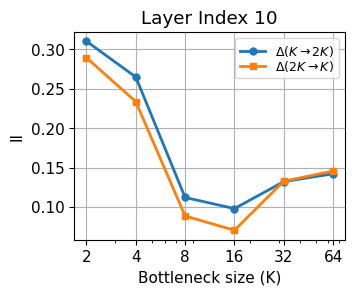

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific pairs of dimensions to plot
dim_pairs = [(2, 4), (4, 8), (8, 16), (16, 32), (32, 64), (64, 128)]
layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

def plot_II_for_layer(layer_index):
    II_values_dim1_to_dim2 = []
    II_values_dim2_to_dim1 = []
    D_values = []

    for dim1, dim2 in dim_pairs:
        # Load II data for dim1 -> dim2
        file_path_1to2 = f"cross_IIs/dim_{dim1}_dim_{dim2}_cross_IIs.np.npy"
        IIs_inter_dims_1to2 = np.load(file_path_1to2)
        
        # Load II data for dim2 -> dim1
        file_path_2to1 = f"cross_IIs/dim_{dim2}_dim_{dim1}_cross_IIs.np.npy"
        IIs_inter_dims_2to1 = np.load(file_path_2to1)
        
        # Extract the II value for the given layer index
        II_dim1_to_dim2 = IIs_inter_dims_1to2[layer_index, layer_index]  # II for dim1 -> dim2
        II_dim2_to_dim1 = IIs_inter_dims_2to1[layer_index, layer_index]  # II for dim2 -> dim1
        
        II_values_dim1_to_dim2.append(II_dim1_to_dim2)
        II_values_dim2_to_dim1.append(II_dim2_to_dim1)
        D_values.append(dim1)  # Using dim1 as the reference dimension for plotting

    # Plotting
    plt.figure()
    plt.plot(D_values, II_values_dim1_to_dim2, marker='o', linestyle='-', color=colors[0], label=r'$\Delta (K \rightarrow 2K)$')
    plt.plot(D_values, II_values_dim2_to_dim1, marker='s', linestyle='-', color=colors[1], label=r'$\Delta (2K \rightarrow K)$')
    
    
    plt.xscale('log')
    plt.xticks(D_values, D_values)
    plt.xlabel('Bottleneck size (K)')
    plt.ylabel('II')
    plt.title(f'Layer Index {layer_index}')
    plt.legend()
    plt.savefig(f"II_vs_D_layer_{layer_index}.png", dpi=300)
    plt.show()
    plt.close()

# Plot for a specific layer index, e.g., layer index 5
plot_II_for_layer(layer_index=10)


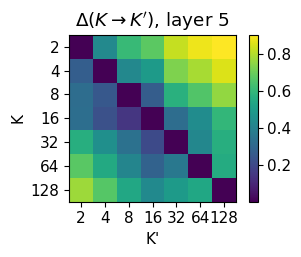

In [40]:

layer_index = 5
dims_matrix = np.zeros((len(dims), len(dims)))

for i, dim1 in enumerate(dims):
    for j, dim2 in enumerate(dims):
        file_path_1to2 = f"cross_IIs/dim_{dim1}_dim_{dim2}_cross_IIs.np.npy"
        IIs_inter_dims_1to2 = np.load(file_path_1to2)
        II_dim1_to_dim2 = IIs_inter_dims_1to2[layer_index, layer_index]

        dims_matrix[i, j] = II_dim1_to_dim2


plt.imshow(dims_matrix, cmap='viridis') 
plt.ylabel("K")
plt.xlabel("K'")


plt.title(r'$\Delta (K \rightarrow K^{\prime})$' + f', layer {layer_index}')
plt.xticks(np.arange(len(dims)), dims)
plt.yticks(np.arange(len(dims)), dims)

plt.colorbar()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"II_matrix_layer_{layer_index}.png", dpi=300)
plt.show()

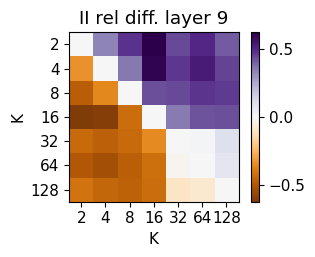

In [41]:
layer_index = 9
dims_matrix = np.zeros((len(dims), len(dims)))

for i, dim1 in enumerate(dims):
    for j, dim2 in enumerate(dims):
        file_path_1to2 = f"cross_IIs/dim_{dim1}_dim_{dim2}_cross_IIs.np.npy"
        file_path_2to1 = f"cross_IIs/dim_{dim2}_dim_{dim1}_cross_IIs.np.npy"
        IIs_inter_dims_1to2 = np.load(file_path_1to2)
        IIs_inter_dims_2to1 = np.load(file_path_2to1)
        II_dim1_to_dim2 = IIs_inter_dims_1to2[layer_index, layer_index]
        II_dim2_to_dim1 = IIs_inter_dims_2to1[layer_index, layer_index]
        
        # delta = np.log(II_dim1_to_dim2) - np.log(II_dim2_to_dim1)
        
        delta = II_dim1_to_dim2 - II_dim2_to_dim1
        delta /= (II_dim1_to_dim2 + II_dim2_to_dim1) / 2
        dims_matrix[i, j] = delta


# c = plt.pcolormesh(dims, dims, delta, shading='auto', cmap='PuOr', vmin=-1, vmax=1)
plt.imshow(dims_matrix, cmap='PuOr') 
plt.ylabel("K")
plt.xlabel("K")

plt.title("II rel diff. " + f"layer {layer_index}")
plt.xticks(np.arange(len(dims)), dims)
plt.yticks(np.arange(len(dims)), dims)

plt.colorbar()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"II_rel_matrix_layer_{layer_index}.png", dpi=300)
plt.show()

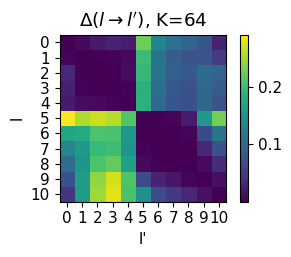

In [42]:
dim = 64

dim1 = dim
dim2 = dim

file_path_1to2 = f"cross_IIs/dim_{dim1}_dim_{dim2}_cross_IIs.np.npy"
IIs_inter_dims_1to2 = np.load(file_path_1to2)

from matplotlib.colors import LogNorm

# fix the range of the colorbar from 0 to 1.0
plt.imshow(IIs_inter_dims_1to2, cmap='viridis')#, norm=LogNorm())#, vmin=0, vmax=1.0)
plt.grid(False)

plt.title(r"$\Delta (l \rightarrow l')$" + f', K={dim1}')
plt.ylabel("l")
plt.xlabel("l'")
plt.xticks(np.arange(11), np.arange(11));
plt.yticks(np.arange(11), np.arange(11));

plt.colorbar()

plt.tight_layout()

plt.savefig(f"II_matrix_layers_dim_{dim}.png", dpi=300)

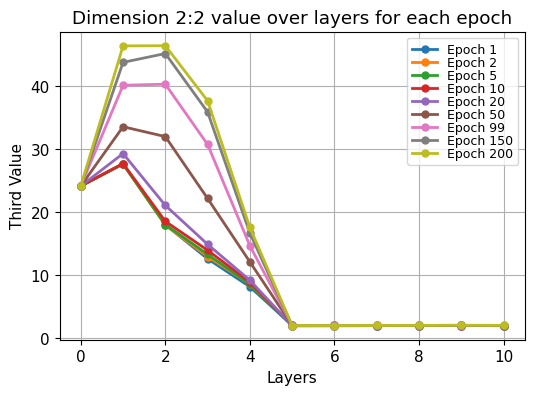

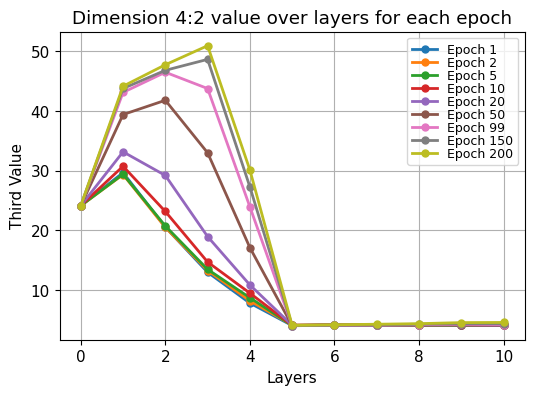

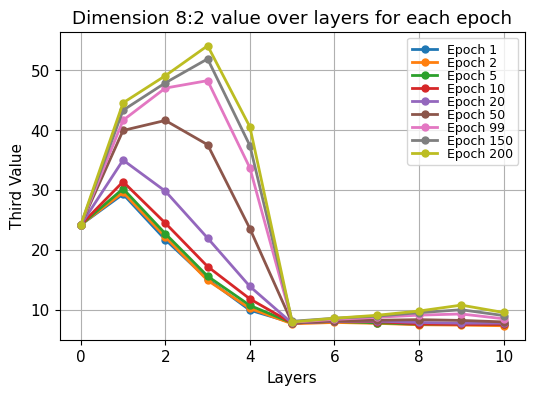

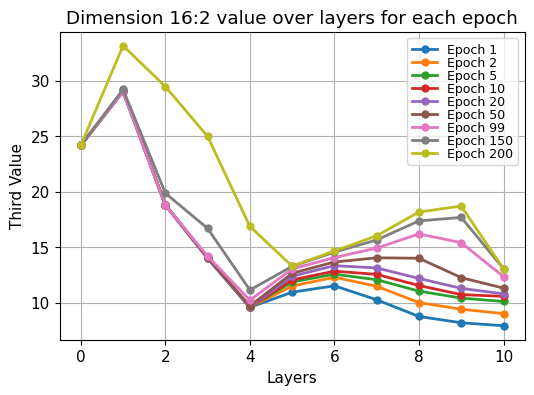

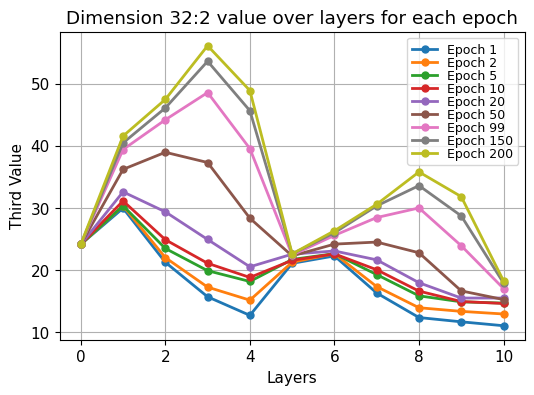

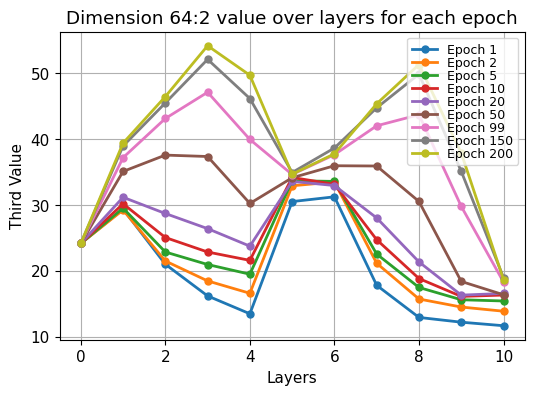

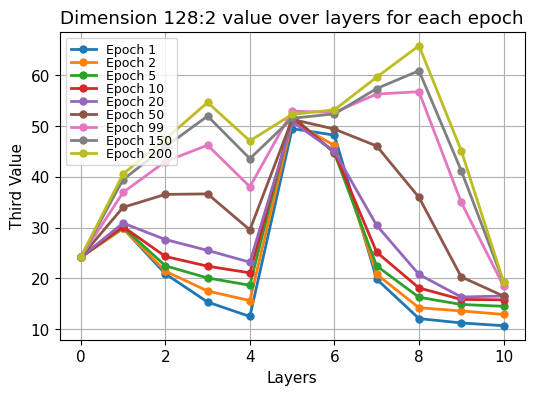

In [43]:
import matplotlib.pyplot as plt
import json

# Load the JSON file
with open('IDs_alt.json') as f:
    data = json.load(f)

# Define epochs, dimensions, and layers
epochs = [1, 2, 5, 10, 20, 50, 99, 150, 200]
dims = [2, 4, 8, 16, 32, 64, 128]
layers = list(range(11))  # 0 to 10
d = 2
# Start plotting
for dim in dims:
    plt.figure(figsize=(6, 4))  # Create a new figure for each dimension
    for epoch in epochs:
        third_values = []
        for layer in layers:
            # Build the key based on the current dimension, epoch, and layer
            key = f"dim_{dim}_epoch_{epoch}_layer{layer}"
            if key in data:
                third_values.append(data[key][d])  # Get the third value (index 2)
            else:
                third_values.append(None)  # Handle missing keys

        # Plot the third values for the current epoch
        plt.plot(layers, third_values, label=f'Epoch {epoch}', marker='o')

    plt.title(f'Dimension {dim}:{d} value over layers for each epoch')
    plt.xlabel('Layers')
    plt.ylabel('Third Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"alt_IDs_{d}_values_dim_{dim}.png", dpi=300)
    plt.show()
